# The Battle of Neighborhoods

# Problem Statement:

The objective of this project is to search all the neighborhoods of New York City for Indian Restaruants and visualize them so that newcomers in New York City know which Indian Restaurants are rated high in the city.  With these findings, they can plan where to live accordingly.

# Questions to be Answered:

# 1. What is the best location in NYC for Indian cuisine?
# 2. Which area lacks Indian Restaurants?
# 3. Where is the best place in NYC to stay if you prefer Indian cuisine?

In [33]:
!pip install geocoder
!pip install folium
!pip install geopy

import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import os
import folium # map rendering library
# Matplotlib and associated plotting modules

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mp
import re
import csv
%matplotlib inline


print('Libraries Imported!!!')

Libraries Imported!!!


Define a function that will retrieve geocodes (i.e. latitude, longitude) using geopy

In [34]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    locatidn = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

Define a function to interact with the Foursquare API and retrieve the top 100 venues within a 1000 meter radius for a given latitude and longitude

In [35]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'SJVNROHFKAQ0CZ5ULIM0V5K5IXUPI2UV1FARMVENUHS3HB4F'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='W1H0JXEDQWHBWX1ZZYT2IXCRTWLGPSNQ2NOGQ5IA4ZKCQKEU' # Foursquare Secret, note there is a daily call quota it
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Define a function to get venue details such as count, rating, and tip counts to be used for creating a ranking.

In [36]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'FM32E0UU4KR1WU4VZIG1F5G1J2XFMKEGNF52UGPTSQ1J1CF1'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='R5SUZ4FBHNDVUMHP15ZKFIKI5VCQBLGPYSFGZY2LYQXMILX2' # Foursquare Secret, note there is a daily call quota it it
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Define a function to get New York City data such as Boroughs, Neighborhoods with their respective latitude and longitude

In [37]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [38]:
new_york_data = get_new_york_data()

In [39]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [40]:
new_york_data.shape

(306, 4)

According to the dataset, there are 306 neighborhoods in New York

With this information, we will now create a Bar Plot of Neighborhoods broken down by NYC borough.

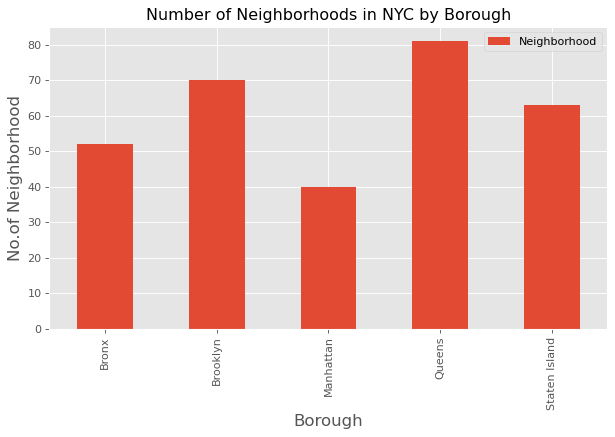

In [41]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 80)
# title
plt.title('Number of Neighborhoods in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
plt.show()

Based on this bar plot, we can see that Queens has the most neighborhoods across all the boroughs of New York City.

Now we will generate a list of Indian Restaurants along with their corresponding neighborhood

In [42]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Resturants in Fordham, Bronx:0
( 18 / 306 ) Indian Resturants in East Tremont, Bronx:0
( 19 / 306 ) Ind

In [43]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill


In [44]:
indian_rest_ny.shape

(147, 4)

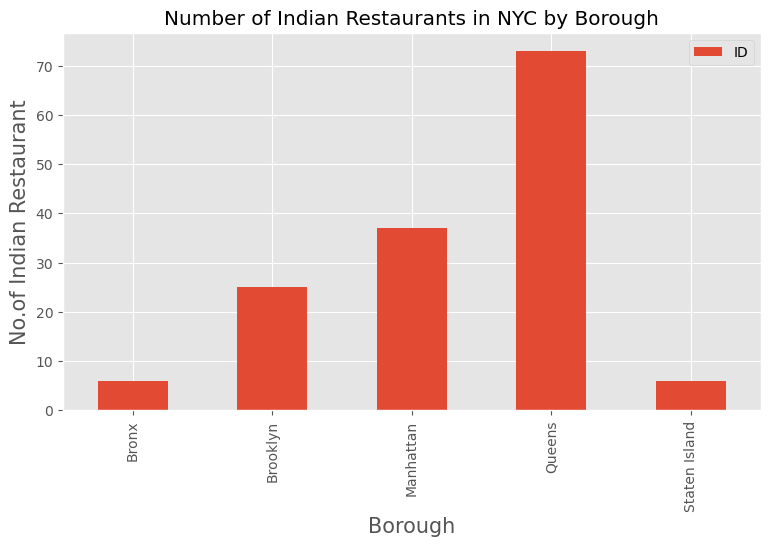

In [45]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Restaurants in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Restaurant', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In the Bar Plot above, it is shown that Queens has the largest number of Indian Restaurants across New York City.

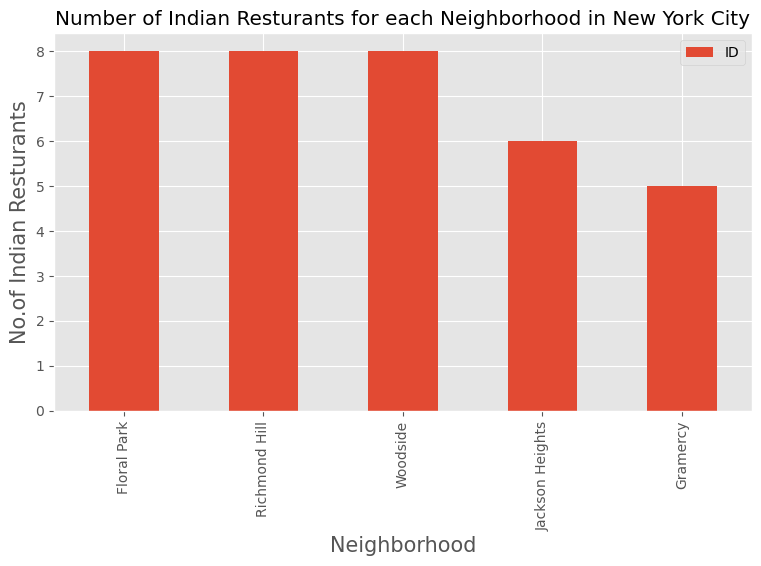

In [46]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [47]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
105,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
106,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
107,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
108,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
109,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
110,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
111,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
112,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


In [48]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Richmond Hill']

,Borough,Neighborhood,ID,Name
75,Queens,Richmond Hill,4b522029f964a520f26927e3,Sohna Punjab
76,Queens,Richmond Hill,5782c9ce498edde587f5aa14,Tikka Indian Grill
77,Queens,Richmond Hill,4f1b77d7e4b044fd359e6d21,India Cafe
78,Queens,Richmond Hill,4babc24ef964a5200ac73ae3,Royal India Palace
79,Queens,Richmond Hill,4adbaef0f964a520ff2921e3,Punjabi Kabab House
80,Queens,Richmond Hill,4bb2bc48a32876b02e0b01fe,Tandoori Hut
81,Queens,Richmond Hill,4edfae15d3e36374e25707a0,Punjabi Virsa Indian Restaurant
82,Queens,Richmond Hill,57d9e9a1498e545076560fef,Punjabi Diner


In [49]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Woodside']

,Borough,Neighborhood,ID,Name
56,Queens,Woodside,4afdcf29f964a520162b22e3,Rajbhog Sweets
57,Queens,Woodside,4b998d3ff964a520fc8235e3,Maharaja Sweets & Snacks
58,Queens,Woodside,4c7060e734443704ca0e245f,Kababish
59,Queens,Woodside,4b189424f964a52043d423e3,Dera
60,Queens,Woodside,5da4fbf091a08400078be19d,Angel Indian Restaurant
61,Queens,Woodside,49ebb18ff964a52016671fe3,Delhi Heights
62,Queens,Woodside,3fd66200f964a52009f11ee3,Jackson Diner
63,Queens,Woodside,4e334b7bb0fb17f64f81a8b2,Premium Sweets & Restaurant


In the above Bar Plot and dataframes, it is seen that Floral Park, Richmond Hill, and Woodside have the highest number of Indian Restaurants at 8.

Now, we will get the ranking of every restaurant to further analyze.

In [50]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row

    # prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      5     7.9    10
( 1 / 147 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.3     2
( 2 / 147 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     5.8     9
( 3 / 147 ) processed
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     7.1     3
( 4 / 147 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.3     2
( 5 / 147 ) processed
                         ID       Name  Likes  Rating  Tips
0  4b5a4dc8f964a520a2bb28e3  Taj Mahal     37     7.9    26
( 6 / 147 ) processed
                         ID          Name  Likes

In [51]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.9,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.8,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,7.1,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2


In [52]:
indian_rest_stats_ny.shape

(147, 7)

In [53]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

In [54]:
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')

In [55]:
indian_rest_stats_ny_csv.shape

(147, 7)

In [56]:
indian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.9,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.8,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,7.1,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2


In [57]:
indian_rest_stats_ny_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       147 non-null    object 
 1   Neighborhood  147 non-null    object 
 2   ID            147 non-null    object 
 3   Name          147 non-null    object 
 4   Likes         147 non-null    int64  
 5   Rating        147 non-null    float64
 6   Tips          147 non-null    int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 8.2+ KB


Here, we typecast Likes and Tips to float64

In [58]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')

In [59]:
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

In [60]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       147 non-null    object 
 1   Neighborhood  147 non-null    object 
 2   ID            147 non-null    object 
 3   Name          147 non-null    object 
 4   Likes         147 non-null    float64
 5   Rating        147 non-null    float64
 6   Tips          147 non-null    float64
dtypes: float64(3), object(4)
memory usage: 8.2+ KB


In [61]:
# Restaurants with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                600
Rating                                 9
Tips                                 150
Name: 42, dtype: object

In [62]:
# Restaurants with maximum Rating
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood           Greenwich Village
ID              5b5a2c9e66f3cd002ca0aab5
Name                      Bombay Bistros
Likes                                 31
Rating                                 9
Tips                                   6
Name: 41, dtype: object

In [63]:
# Restaurants with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                    Gramercy
ID              4a70a75bf964a52016d81fe3
Name                 Bhatti Indian Grill
Likes                                424
Rating                               8.8
Tips                                 163
Name: 49, dtype: object

In [64]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [65]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
29,Greenwich Village,9.00
67,Tribeca,9.00
72,West Village,8.95
49,Prospect Heights,8.90
50,Prospect Lefferts Gardens,8.70
10,Chelsea,8.70
70,Upper West Side,8.55
45,North Side,8.50
60,South Side,8.50
22,Fort Greene,8.50


In [66]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [67]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Brooklyn,6.552000
0,Bronx,5.566667
2,Manhattan,5.348649
3,Queens,0.000000
4,Staten Island,0.000000


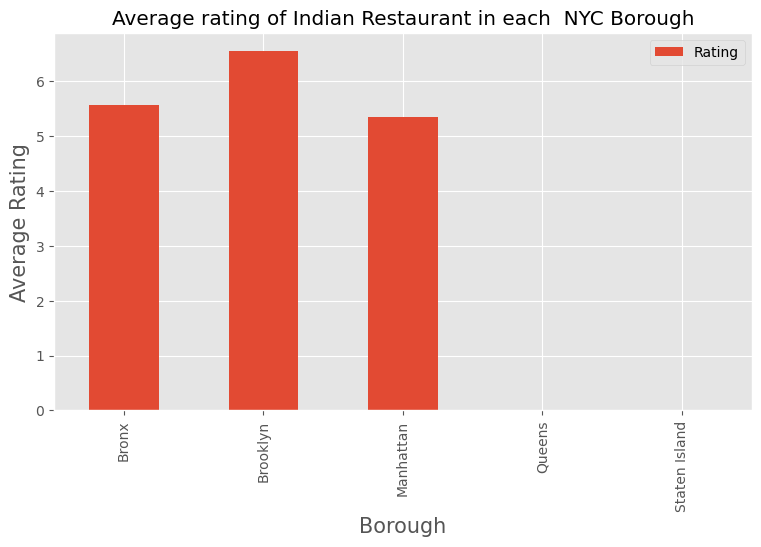

In [68]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Restaurant in each  NYC Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

As displayed on the Bar Plot, we can see that Brooklyn has the highest average rating for Indian Restaurants.

Now we will visualize all indian restaurants with an average rating of 8.0 or greater on a map.

In [69]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]

In [70]:
ny_neighborhood_stats

,Neighborhood,Average Rating
9,Central Harlem,8.000000
10,Chelsea,8.700000
12,Clinton Hill,8.150000
16,East Flatbush,8.400000
22,Fort Greene,8.500000
29,Greenwich Village,9.000000
40,Manhattan Valley,8.050000
45,North Side,8.500000
49,Prospect Heights,8.900000
50,Prospect Lefferts Gardens,8.700000


In [71]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [72]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [73]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Borough,Neighborhood,Latitude,Longitude,Average Rating
13,Manhattan,Tribeca,40.721522,-74.010683,9.00
6,Manhattan,Greenwich Village,40.726933,-73.999914,9.00
16,Manhattan,West Village,40.734434,-74.006180,8.95
9,Brooklyn,Prospect Heights,40.676822,-73.964859,8.90
2,Staten Island,Chelsea,40.594726,-74.189560,8.70
1,Manhattan,Chelsea,40.744035,-74.003116,8.70
10,Brooklyn,Prospect Lefferts Gardens,40.658420,-73.954899,8.70
14,Manhattan,Upper West Side,40.787658,-73.977059,8.55
5,Brooklyn,Fort Greene,40.688527,-73.972906,8.50
8,Brooklyn,North Side,40.714823,-73.958809,8.50


In [74]:
# create map and display it
ny_map = folium.Map(location=(40.693943, -73.985880), zoom_start=12)

In [75]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [76]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

# Map of the Best Neighborhoods in New York that have the highest average rating for Indian Restaurants

In [77]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

# Findings:

1. Greenwich Village, West Village, and Tribeca have the highest average ratings for Indian Restaurants in NYC.
3. Staten Island has a lack of Indian Restaurants in NYC.
4. Manhattan is the most recommended place to stay if you would like Indian Cuisine.

# Recommendation

The West Village or Tribeca area would be the best place to start a restaurant because:
1. it is the third most populous urban area in New York City (NYC).
2. it has a population density of 27,826 people per square km, highest of any borough in the United States.
3. it has some of the top rated Indian restaurants located in that area
4. It has the second highest Asian ethnic minority population in NYC.